In [1]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime,timedelta
import matplotlib.pyplot as plt 
%matplotlib inline
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

  0%|          | 0/655750 [00:00<?, ?it/s]

In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

  0%|          | 0/655750 [00:00<?, ?it/s]

In [6]:
key_date = user_index[str(max_user_id)]['date']
for i in tqdm(range(max_user_id,id_for_1_jan_2023,-1)):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date']> key_date:
            user_index[str(i)]['date'] = None
        else:
            key_date = user_index[str(i)]['date']

  0%|          | 0/20302 [00:00<?, ?it/s]

In [7]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [8]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

  0%|          | 0/397456 [00:00<?, ?it/s]

In [9]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

  0%|          | 0/397456 [00:00<?, ?it/s]

In [10]:
with open("../data/Overlap_commitments.json",'r') as fp:
    overlap = json.load(fp)

In [11]:
overlap_keys = set()
for k,v in overlap.items():
    for i in v:
        overlap_keys.add(i)

In [12]:
len(overlap_keys)

167511

Dataframe

In [13]:
# count = 0
# for k,v in commitment_index.items():
#     ratio = v['sucessful']*100/v['no_of_reports']
#     if v['days_per_reporting']!=1.0 and v['days_per_reporting']!=7.0 and v['no_of_reports']>1:
#         if v['days_per_reporting']<7.0:
#             count+=1
# #         print(v['days_per_reporting'], ratio, v['no_of_reports'])
# count

In [14]:
lifeline_raw_data = []
for k,v in tqdm(commitment_index.items()):
    ratio = v['sucessful']*100/v['no_of_reports']
    sample = [ratio]
    if ratio == 100.0:
        sample.append(0)
    else:
        sample.append(1)
    
    if "_reverted" in v['type_of_stake']:
        sample.append('No stakes')
    else:
        sample.append(v['type_of_stake'])
    sample.append(v['self_refree'])
    

    if v['start_date'].day == 1 and v['start_date'].month == 1:
        sample.append(True)
    else:
        sample.append(False)
    
    
    if v['start_date'].day == 1:
        sample.append(True)
    else:
        sample.append(False)
        
    if v['start_date'].weekday() == 0:
        sample.append(True)
    else:
        sample.append(False)
    
    if k in overlap_keys:
        sample.append(True)
    else:
        sample.append(False)
        
    if v['days_per_reporting'] == 7.0:
        sample.append("week")
    elif v['days_per_reporting'] == 1.0:
        sample.append("daily")
    elif v['no_of_reports']>1:
        sample.append("other")
    else:
        sample.append("ignore")
        
    if v['no_of_supporters']==0:
        sample.append(False)
    else:
        sample.append(True)
        
    lifeline_raw_data.append(sample)

  0%|          | 0/397456 [00:00<?, ?it/s]

In [15]:
lifeline_df = pd.DataFrame(lifeline_raw_data,columns=['success_percentage','observed','type of stake','self refree','first_day_of_year','first_day_month','Monday','overlap','days_per_reporting','support'])



In [16]:
lifeline_df

,success_percentage,observed,type of stake,self refree,first_day_of_year,first_day_month,Monday,overlap,days_per_reporting,support
0,0.000000,1,No stakes,True,False,True,False,True,week,False
1,0.000000,1,No stakes,True,False,True,False,True,ignore,False
2,0.000000,1,No stakes,True,False,True,False,True,week,False
3,0.000000,1,No stakes,True,False,True,False,True,week,False
4,0.000000,1,No stakes,True,False,True,False,True,week,False
...,...,...,...,...,...,...,...,...,...,...
397451,0.000000,1,No stakes,True,False,False,True,False,ignore,False
397452,42.857143,1,No stakes,True,False,False,False,False,daily,False
397453,50.000000,1,Charity,True,False,False,False,False,daily,False
397454,50.000000,1,Money to a friend,True,False,False,True,True,daily,False


In [17]:
lifeline_df = lifeline_df[lifeline_df['success_percentage']>0.0]

In [18]:
lifeline_df.shape

(194307, 10)

In [19]:
lifeline_df['observed'].value_counts()

observed
1    119821
0     74486
Name: count, dtype: int64

In [20]:
lifeline_df['type of stake'].value_counts()

type of stake
No stakes            86720
Anti-charity         57631
Charity              24388
Money to a friend    20067
stickK                5501
Name: count, dtype: int64

In [21]:
lifeline_df['self refree'].value_counts()

self refree
True     136460
False     57847
Name: count, dtype: int64

In [22]:
lifeline_df['first_day_of_year'].value_counts()

first_day_of_year
False    192129
True       2178
Name: count, dtype: int64

In [23]:
lifeline_df['first_day_month'].value_counts()

first_day_month
False    185247
True       9060
Name: count, dtype: int64

In [24]:
lifeline_df['Monday'].value_counts()

Monday
False    151809
True      42498
Name: count, dtype: int64

In [25]:
lifeline_df['overlap'].value_counts()

overlap
False    97778
True     96529
Name: count, dtype: int64

In [26]:
lifeline_df['days_per_reporting'].value_counts()

days_per_reporting
week      140829
ignore     26728
daily      26613
other        137
Name: count, dtype: int64

In [27]:
lifeline_df['support'].value_counts()

support
False    168184
True      26123
Name: count, dtype: int64

# Survival Analysis

Full curve

In [28]:
kmf = KaplanMeierFitter()

In [29]:
T = lifeline_df['success_percentage']
E = lifeline_df['observed']

In [ ]:
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 194307 total observations, 74486 right-censored observations>

<Axes: xlabel='timeline'>

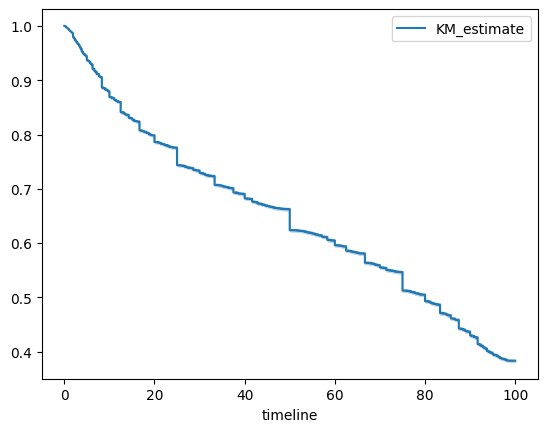

In [31]:
kmf.plot_survival_function()

Self refree

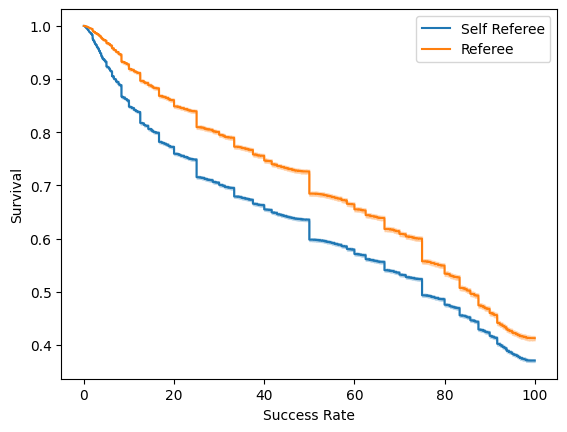

In [47]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

self_ref_df = (lifeline_df['self refree']==True)

kmf.fit(T[self_ref_df], event_observed=E[self_ref_df], label="Self Referee")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~self_ref_df], event_observed=E[~self_ref_df], label="Referee")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_referee.pdf",bbox_inches='tight')

In [48]:
results = logrank_test(T[self_ref_df], T[~self_ref_df], E[self_ref_df], E[~self_ref_df], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         731.66 <0.005    532.86

Type of Stake

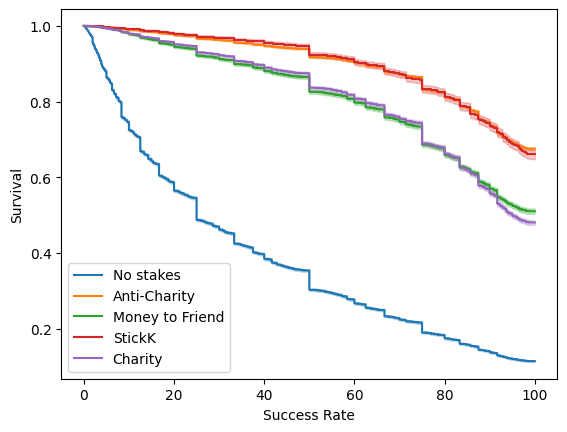

In [49]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

no_s = (lifeline_df['type of stake']=='No stakes')
AC = (lifeline_df['type of stake']=='Anti-charity')
C = (lifeline_df['type of stake']=='Charity')
MtoF = (lifeline_df['type of stake']=='Money to a friend')
S = (lifeline_df['type of stake']=='stickK')

kmf.fit(T[no_s], event_observed=E[no_s], label="No stakes")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[AC], event_observed=E[AC], label="Anti-Charity")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[MtoF], event_observed=E[MtoF], label="Money to Friend")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[S], event_observed=E[S], label="StickK")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[C], event_observed=E[C], label="Charity")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_stake_type.pdf",bbox_inches='tight')

In [50]:
results = logrank_test(T[no_s], T[C], E[no_s], E[C], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       19766.34 <0.005       inf

In [51]:
results = logrank_test(T[no_s], T[AC], E[no_s], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       64493.83 <0.005       inf

In [52]:
results = logrank_test(T[C], T[AC], E[C], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3165.01 <0.005       inf

In [53]:
results = logrank_test(T[C], T[MtoF], E[C], E[MtoF], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          19.61 <0.005     16.68

In [54]:
results = logrank_test(T[S], T[AC], E[S], E[AC], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.49 0.06      4.02

Start date

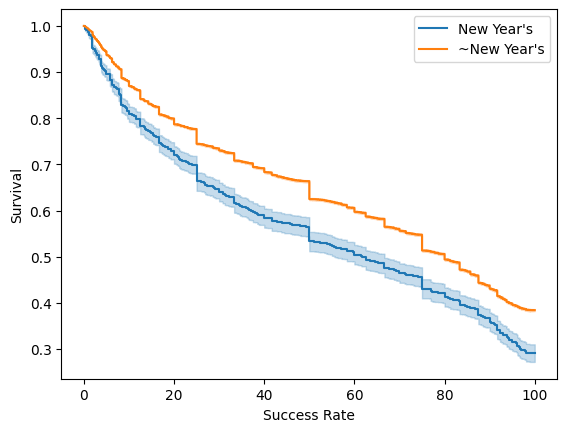

In [55]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

first_day_year = (lifeline_df['first_day_of_year']==True)

kmf.fit(T[first_day_year], event_observed=E[first_day_year], label="New Year's")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~first_day_year], event_observed=E[~first_day_year], label="~New Year's")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_new_year.pdf",bbox_inches='tight')

In [56]:
results = logrank_test(T[first_day_year], T[~first_day_year], E[first_day_year], E[~first_day_year], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         112.19 <0.005     84.67

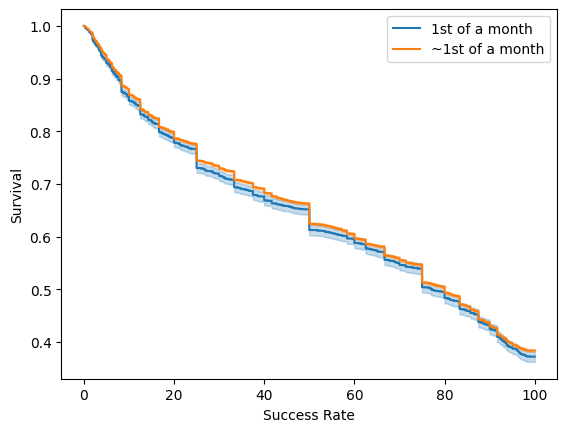

In [57]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

first_day_month = (lifeline_df['first_day_month']==True)

kmf.fit(T[first_day_month], event_observed=E[first_day_month], label="1st of a month")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~first_day_month], event_observed=E[~first_day_month], label="~1st of a month")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_new_month.pdf",bbox_inches='tight')

In [83]:
results = logrank_test(T[first_day_month], T[~first_day_month], E[first_day_month], E[~first_day_month], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.15 0.01      6.25

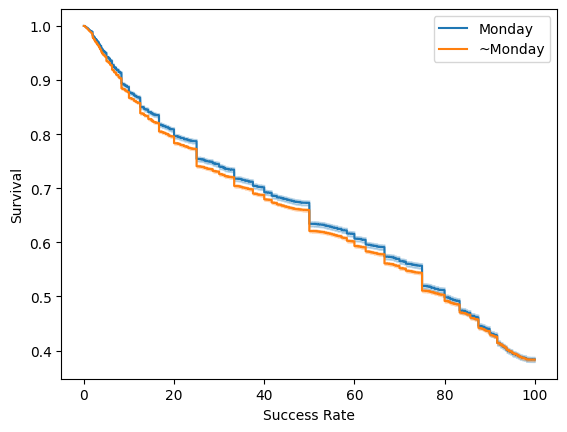

In [58]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

monday = (lifeline_df['Monday']==True)

kmf.fit(T[monday], event_observed=E[monday], label="Monday")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~monday], event_observed=E[~monday], label="~Monday")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_new_monday.pdf",bbox_inches='tight')

In [59]:
results = logrank_test(T[monday], T[~monday], E[monday], E[~monday], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.66 0.03      5.01

Overlap

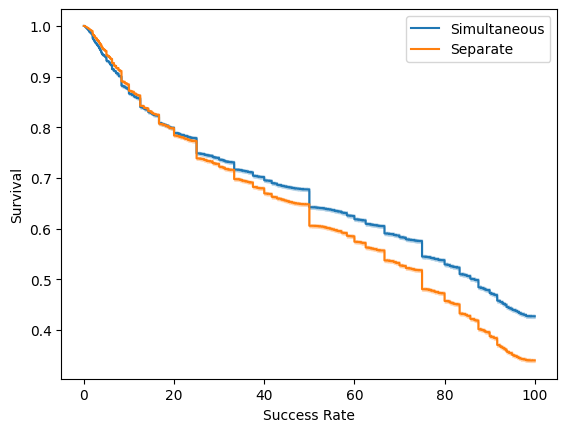

In [60]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

overlap = (lifeline_df['overlap']==True)

kmf.fit(T[overlap], event_observed=E[overlap], label="Simultaneous")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~overlap], event_observed=E[~overlap], label="Separate")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_overlap.pdf",bbox_inches='tight')

In [61]:
results = logrank_test(T[overlap], T[~overlap], E[overlap], E[~overlap], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1201.44 <0.005    872.10

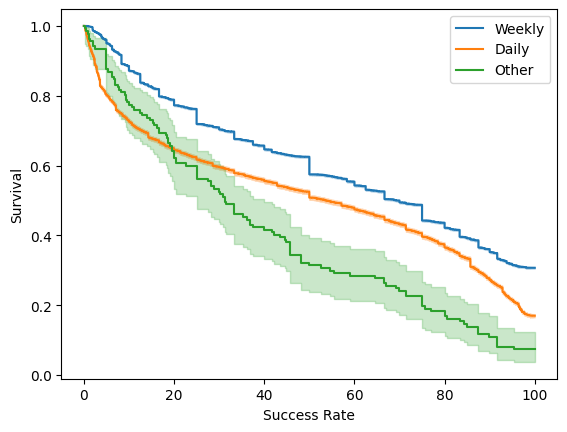

In [62]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

w = (lifeline_df['days_per_reporting']=='week')
d = (lifeline_df['days_per_reporting']=='daily')
o = (lifeline_df['days_per_reporting']=='other')


kmf.fit(T[w], event_observed=E[w], label="Weekly")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[d], event_observed=E[d], label="Daily")
kmf.plot_survival_function(ax=ax)

# kmf.fit(T[l], event_observed=E[l], label="low")
# kmf.plot_survival_function(ax=ax)

# kmf.fit(T[h], event_observed=E[h], label="high")
# kmf.plot_survival_function(ax=ax)

kmf.fit(T[o], event_observed=E[o], label="Other")
kmf.plot_survival_function(ax=ax)

plt.xlabel("Success Rate")
plt.ylabel("Survival")
plt.savefig("../figures/sur_reportin_period.pdf",bbox_inches='tight')

In [63]:
results = logrank_test(T[w], T[d], E[w], E[d], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2490.89 <0.005       inf

In [64]:
results = logrank_test(T[o], T[d], E[o], E[d], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.70 <0.005     14.48

<Axes: xlabel='timeline'>

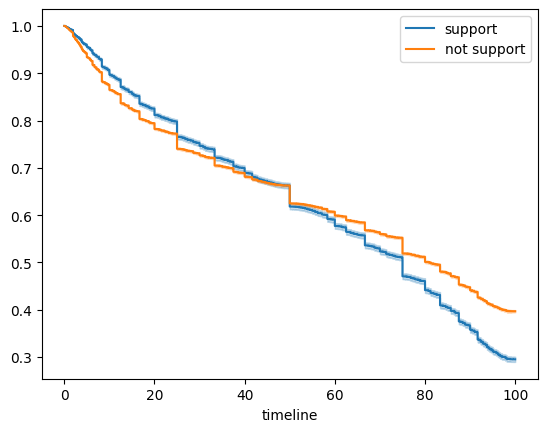

In [65]:
kmf = KaplanMeierFitter()
ax = plt.subplot(111)

support = (lifeline_df['support']==True)

kmf.fit(T[support], event_observed=E[support], label="support")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~support], event_observed=E[~support], label="not support")
kmf.plot_survival_function(ax=ax)

In [66]:
results = logrank_test(T[support], T[~support], E[support], E[~support], alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         556.65 <0.005    406.43

# COX Regression

In [68]:
def get_outlier(data):
    Q1 = np.percentile(data, 25, method = 'midpoint') 
    Q2 = np.percentile(data, 50, method = 'midpoint') 
    Q3 = np.percentile(data, 75, method = 'midpoint')
    
    IQR = Q3 - Q1
    
    low_lim = max(Q1 - 1.5 * IQR,min(data))
    up_lim = min(Q3 + 1.5 * IQR, max(data))
    
    return Q2, IQR, low_lim, up_lim

In [69]:
cox_raw_data = []
for k,v in tqdm(commitment_index.items()):
    ratio = v['sucessful']*100/v['no_of_reports']
    sample = [ratio]
    if ratio == 100.0:
        sample.append(0)
    else:
        sample.append(1)
        
    sample.append(v['stake_per_period'])
#     sample.append(v['total_stake'])
    sample.append(v['length_in_days'])
    sample.append(v['no_of_supporters'])
#     sample.append(v['days_per_reporting'])
    sample.append(v['no_of_reports'])
    
        
    cox_raw_data.append(sample)

  0%|          | 0/397456 [00:00<?, ?it/s]

In [70]:
# Cox_df = pd.DataFrame(cox_raw_data,columns=['success_percentage','observed','stake_per_period','total_stake','length_in_days','no_of_supporters','days_per_reporting'])

Cox_df = pd.DataFrame(cox_raw_data,columns=['success_percentage','observed','stake_per_period','length_in_days','no_of_supporters','no_of_reports'])

In [71]:
Cox_df

,success_percentage,observed,stake_per_period,length_in_days,no_of_supporters,no_of_reports
0,0.000000,1,0.0,112,0,16
1,0.000000,1,0.0,53,0,1
2,0.000000,1,0.0,56,0,8
3,0.000000,1,0.0,112,0,16
4,0.000000,1,0.0,56,0,8
...,...,...,...,...,...,...
397451,0.000000,1,0.0,2,0,1
397452,42.857143,1,0.0,7,0,7
397453,50.000000,1,5.0,2,0,2
397454,50.000000,1,5.0,2,0,2


In [72]:
Cox_df = Cox_df[Cox_df['success_percentage']>0.0]

In [73]:
Cox_df.shape

(194307, 6)

In [74]:
Q2, IQR, low_lim, up_lim = get_outlier(Cox_df['stake_per_period'].to_list())

Cox_df = Cox_df[(Cox_df['stake_per_period']>=low_lim) & (Cox_df['stake_per_period']<=up_lim)]
Cox_df.shape

(173525, 6)

In [75]:
Q2, IQR, low_lim, up_lim = get_outlier(Cox_df['length_in_days'].to_list())

Cox_df = Cox_df[(Cox_df['length_in_days']>=low_lim) & (Cox_df['length_in_days']<=up_lim)]
Cox_df.shape

(157730, 6)

In [76]:
Q2, IQR, low_lim, up_lim = get_outlier(list(set(Cox_df['no_of_supporters'].to_list())))

Cox_df = Cox_df[(Cox_df['no_of_supporters']>=low_lim) & (Cox_df['no_of_supporters']<=up_lim)]
Cox_df.shape

(157730, 6)

In [77]:


# Q2, IQR, low_lim, up_lim = get_outlier(list(set(Cox_df['days_per_reporting'].to_list())))

# Cox_df = Cox_df[(Cox_df['days_per_reporting']>=low_lim) & (Cox_df['days_per_reporting']<=up_lim)]
# Cox_df.shape

In [78]:
Q2, IQR, low_lim, up_lim = get_outlier(Cox_df['no_of_reports'].to_list())

Cox_df = Cox_df[(Cox_df['no_of_reports']>=low_lim) & (Cox_df['no_of_reports']<=up_lim)]
Cox_df.shape

(147379, 6)

In [79]:
Cox_df.shape

(147379, 6)

In [80]:
Cox_df['observed'].value_counts()

observed
1    91727
0    55652
Name: count, dtype: int64

In [81]:
cph = CoxPHFitter()

In [82]:
cph.fit(Cox_df, duration_col='success_percentage', event_col='observed')

<lifelines.CoxPHFitter: fitted with 147379 total observations, 55652 right-censored observations>

In [92]:
cph.print_summary(decimals=4)

<lifelines.CoxPHFitter: fitted with 147379 total observations, 55652 right-censored observations>
             duration col = 'success_percentage'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 147379
number of events observed = 91727
   partial log-likelihood = -1021704.0285
         time fit was run = 2023-08-22 19:30:26 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
stake_per_period -0.0540     0.9474     0.0004          -0.0548          -0.0532               0.9467               0.9482
length_in_days    0.0045     1.0045     0.0001           0.0043           0.0046               1.0043               1.0046
no_of_supporters -0.0205     0.9797     0.0038          -0.0279          -0.0131               0.9725               0.9870
no_of_reports     0.0437     1.0447     0.0005           0.0427           0.0446               1.0437               1.0457

                   cmp to         z      p   -log2(p)
covariate                                            
stake_per_period   0.0000 -130.0072 <5e-05        inf
length_in_days     0.0000   57.6594 <5e-05        inf
no_of_supporters   0.0000   -5.4376 <5e-05    24.1420
no_of_reports      0.0000   89.2486 <5e-05        inf
---
Concordance = 0.7589
Partial AIC = 2043416.0570
log-likelihood ratio test = 64779.2469 on 4 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

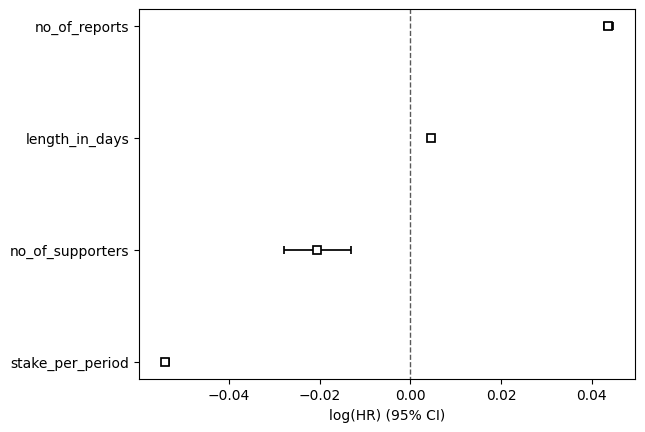

In [109]:
cph.plot()

<Axes: >

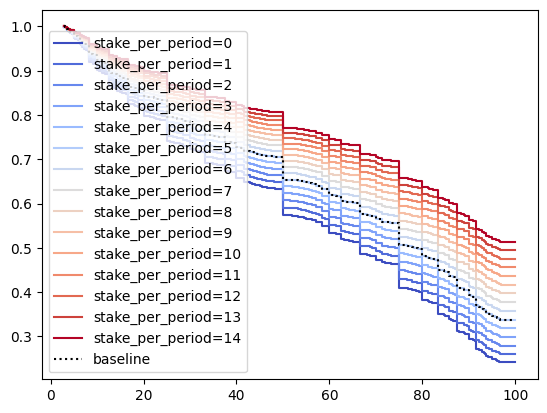

In [110]:
cph.plot_partial_effects_on_outcome(covariates='stake_per_period', values=[i for i in range(0,15,1)], cmap='coolwarm')

<Axes: >

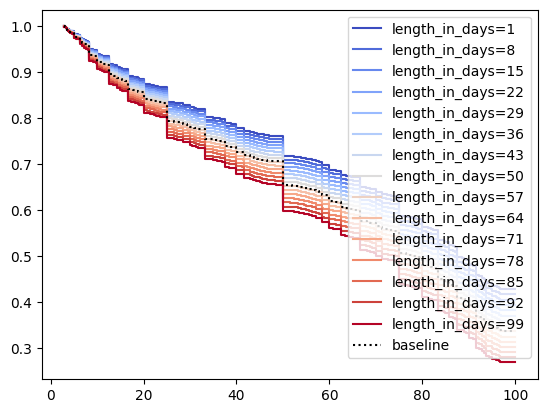

In [111]:
cph.plot_partial_effects_on_outcome(covariates='length_in_days', values=[i for i in range(1,100,7)], cmap='coolwarm')

<Axes: >

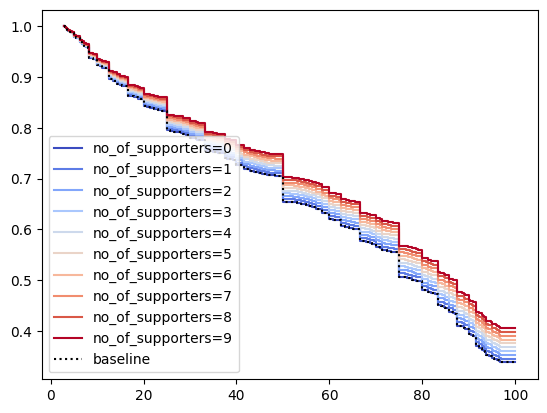

In [112]:
cph.plot_partial_effects_on_outcome(covariates='no_of_supporters', values=[i for i in range(0,10,1)], cmap='coolwarm')

In [113]:
# cph.plot_partial_effects_on_outcome(covariates='days_per_reporting', values=[i for i in range(1,10,1)], cmap='coolwarm')

<Axes: >

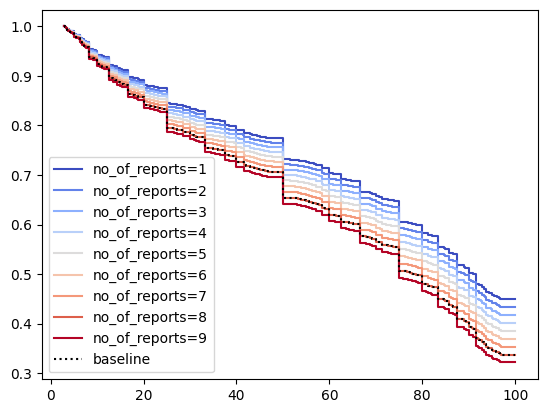

In [114]:
cph.plot_partial_effects_on_outcome(covariates='no_of_reports', values=[i for i in range(1,10,1)], cmap='coolwarm')